In [2]:
%matplotlib inline

In [3]:
import sys, os
import numpy as np
import SimpleITK as sitk
import matplotlib.pylab as plt
import glob
plt.rcParams['figure.figsize'] = (8,6)

Aggregate the moving image data, sort it, and put it into a single itk object.

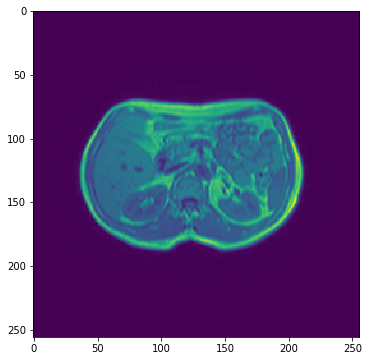

In [4]:
#dataRoot='/pghbio/dbmi/batmanlab/Data/CombinedHealthyAbdominalOrganSegmentation/MR_data_batch1/1/T2SPIR'
dataRoot='/pghbio/dbmi/batmanlab/Data/CombinedHealthyAbdominalOrganSegmentation/MR_data_batch1/1/T1DUAL'
moving_img_list = []
for i,fn in enumerate(sorted(glob.glob( dataRoot + '/DICOM_anon/*dcm'))):
    #print(fn)
    if 'DUAL' in dataRoot:
        if i % 2 == 0:
            continue
    if i == 1:
        tmp_moving_image = sitk.ReadImage(fn)
    #print(sitk.ReadImage(fn).GetOrigin())
    #print(sitk.ReadImage(fn).GetSize())
    moving_img_list.append(sitk.GetArrayFromImage(sitk.ReadImage(fn)))
plt.imshow(moving_img_list[22][0,:,:])
    
moving_image_series = np.zeros((len(moving_img_list),moving_img_list[0].shape[1], moving_img_list[0].shape[2] ), dtype=np.float32)
for i,img in enumerate(moving_img_list):
    moving_image_series[i,:,:] = img
    
moving_image = sitk.GetImageFromArray(moving_image_series)
moving_image.SetDirection(tmp_moving_image.GetDirection())
moving_image.SetOrigin(tmp_moving_image.GetOrigin())
moving_image.SetSpacing(tmp_moving_image.GetSpacing())

Do the same wrangling for the png segmentation images.

/pghbio/dbmi/batmanlab/Data/CombinedHealthyAbdominalOrganSegmentation/MR_data_batch1/1/T1DUAL/Ground/liver_001.png
/pghbio/dbmi/batmanlab/Data/CombinedHealthyAbdominalOrganSegmentation/MR_data_batch1/1/T1DUAL/Ground/liver_002.png
/pghbio/dbmi/batmanlab/Data/CombinedHealthyAbdominalOrganSegmentation/MR_data_batch1/1/T1DUAL/Ground/liver_003.png
/pghbio/dbmi/batmanlab/Data/CombinedHealthyAbdominalOrganSegmentation/MR_data_batch1/1/T1DUAL/Ground/liver_004.png
/pghbio/dbmi/batmanlab/Data/CombinedHealthyAbdominalOrganSegmentation/MR_data_batch1/1/T1DUAL/Ground/liver_005.png
/pghbio/dbmi/batmanlab/Data/CombinedHealthyAbdominalOrganSegmentation/MR_data_batch1/1/T1DUAL/Ground/liver_006.png
/pghbio/dbmi/batmanlab/Data/CombinedHealthyAbdominalOrganSegmentation/MR_data_batch1/1/T1DUAL/Ground/liver_007.png
/pghbio/dbmi/batmanlab/Data/CombinedHealthyAbdominalOrganSegmentation/MR_data_batch1/1/T1DUAL/Ground/liver_008.png
/pghbio/dbmi/batmanlab/Data/CombinedHealthyAbdominalOrganSegmentation/MR_data_ba

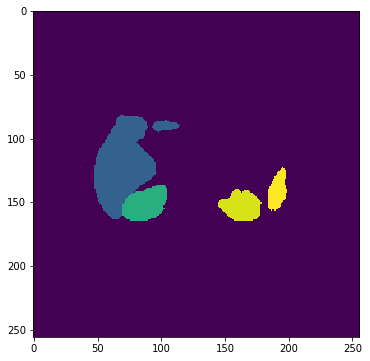

In [5]:
seg_image_list = []
for i,fn in enumerate(sorted(glob.glob( dataRoot + '/Ground/*png'))):
    print(fn)
    seg_image_list.append(sitk.GetArrayFromImage(sitk.ReadImage(fn)))
    
plt.figure()
plt.imshow(seg_image_list[22][:,:])

seg_image= np.zeros((len(seg_image_list),seg_image_list[0].shape[0], seg_image_list[0].shape[1] ), dtype=np.float32)
for i,img in enumerate(seg_image_list):
    seg_image[i,:,:] = img
    
    
seg_image= sitk.GetImageFromArray(seg_image)
seg_image.SetDirection(tmp_moving_image.GetDirection())
seg_image.SetOrigin(tmp_moving_image.GetOrigin())
seg_image.SetSpacing(tmp_moving_image.GetSpacing())

Now lets get the fixed images from the MRE dataset

Reading Dicom directory: /pghbio/dbmi/batmanlab/bpollack/predictElasticity/data/MRE/375/DICOM/ST00001
Image size: 512 512 4
Image dims: 0.6641 0.6641 9.199996948242188
(512, 512, 4)
(-192.97500610351562, -176.17799377441406, 103.55599975585938)


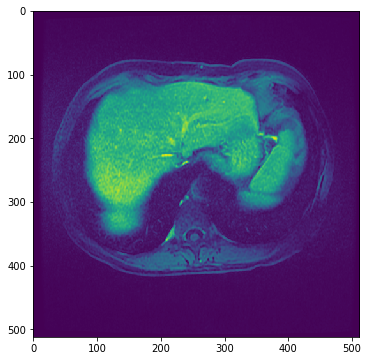

In [6]:
temp_data_dir = '/pghbio/dbmi/batmanlab/bpollack/predictElasticity/data/MRE/375/DICOM/ST00001'
full_data_dir = '/pghbio/dbmi/batmanlab/bpollack/predictElasticity/data/MRE/'
subdir_names = ['SE00001','SE00002','SE00003','SE00004','SE00005','SE00006']
for fn in ['SE00003']:
    print( "Reading Dicom directory:", temp_data_dir )
    
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames( temp_data_dir + '/' + fn )
    reader.SetFileNames(dicom_names)
    reader.MetaDataDictionaryArrayUpdateOn()
    reader.LoadPrivateTagsOn()
    image = reader.Execute()
    size = image.GetSize()
    dims = image.GetSpacing()
    print( "Image size:", size[0], size[1], size[2] )
    print( "Image dims:", dims[0], dims[1], dims[2] )
fixed_image = image
fixed_image.GetPixelIDTypeAsString()
caster = sitk.CastImageFilter()
caster.SetOutputPixelType( sitk.sitkFloat32)
fixed_image = caster.Execute( fixed_image )
print(fixed_image.GetSize())
print(fixed_image.GetOrigin())
plt.imshow(sitk.GetArrayFromImage(fixed_image)[3])

Now let's interpolate everything so we're dealing with the same dimensions.

In [7]:
def interp_and_norm(input_image, z_spacing):
    reference_origin = np.zeros(3)
    reference_direction = np.identity(3).flatten()
    reference_size = [300, 300, 4]
    reference_spacing = [1.4,1.4, z_spacing] #1.4mm x 1.4mm x 11.5mm

    reference_image = sitk.Image(reference_size, 2)
    reference_image.SetOrigin(reference_origin)
    reference_image.SetSpacing(reference_spacing)
    reference_image.SetDirection(reference_direction)
    reference_center = np.array(reference_image.TransformContinuousIndexToPhysicalPoint(np.array(reference_image.GetSize())/2.0))
    transform = sitk.AffineTransform(3)
    transform.SetMatrix(input_image.GetDirection())
    transform.SetTranslation(np.array(input_image.GetOrigin()) - reference_origin)

    centering_transform = sitk.TranslationTransform(3)
    img_center = np.array(input_image.TransformContinuousIndexToPhysicalPoint(np.array(input_image.GetSize())/2.0))
    centering_transform.SetOffset(np.array(transform.GetInverse().TransformPoint(img_center) - reference_center))
    centered_transform = sitk.Transform(transform)
    centered_transform.AddTransform(centering_transform)

    new_input_image = sitk.Resample(input_image, reference_image, centered_transform, sitk.sitkNearestNeighbor)
    new_input_image = sitk.Normalize(new_input_image)

    fig, axs = plt.subplots(1, 4, constrained_layout=True, figsize=(20,6), sharex=False, sharey=False)
    axs = axs.flatten()
    axs[0].imshow(sitk.GetArrayFromImage(new_input_image)[0,:,:])
    axs[1].imshow(sitk.GetArrayFromImage(new_input_image)[1,:,:])
    axs[2].imshow(sitk.GetArrayFromImage(new_input_image)[2,:,:])
    axs[3].imshow(sitk.GetArrayFromImage(new_input_image)[3,:,:]) 
    plt.show()
    return new_input_image

In [8]:
#interpolate and normalize the images
#fixed_image = interp_and_norm(fixed_image, fixed_image.GetSpacing()[2])
#moving_image = interp_and_norm(moving_image, fixed_image.GetSpacing()[2])
#seg_image = interp_and_norm(seg_image, fixed_image.GetSpacing()[2])

# Registration

Going to copy and paste in some methods from simpleITK notebook, attempt basic registration.

In [9]:
from ipywidgets import interact, fixed
from IPython.display import clear_output

# Callback invoked by the interact IPython method for scrolling through the image stacks of
# the two images (moving and fixed).
def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1,2,figsize=(10,8))
    
    # Draw the fixed image in the first subplot.
    plt.subplot(1,2,1)
    plt.imshow(fixed_npa[fixed_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('fixed image')
    plt.axis('off')
    
    # Draw the moving image in the second subplot.
    plt.subplot(1,2,2)
    plt.imshow(moving_npa[moving_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('moving image')
    plt.axis('off')
    
    plt.show()

# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space. 
def display_images_with_alpha(image_z, alpha, fixed, moving):
    img = (1.0 - alpha)*fixed[:,:,image_z] + alpha*moving[:,:,image_z] 
    plt.imshow(sitk.GetArrayViewFromImage(img));
    plt.axis('off')
    plt.show()
    
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.    
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values)) 

In [45]:
# Similarity metric settings.
#registration_method.SetMetricAsANTSNeighborhoodCorrelation(radius=5)
#registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
#registration_method.SetMetricAsJointHistogramMutualInformation()

# Optimizer settings.
#registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)

#registration_method.SetOptimizerAsGradientDescentLineSearch(5.0,
#                                          100,
#                                          convergenceMinimumValue=1e-6,
#                                          convergenceWindowSize=5)

def reg_func(fixed_image, moving_image, method_number=0):
    # Common reg settings
    registration_method = sitk.ImageRegistrationMethod()
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)
    registration_method.SetInterpolator(sitk.sitkLinear)
    registration_method.SetOptimizerScalesFromPhysicalShift()
    
    if method_number == 0: # Euler and BSpline
        #Transforms
        center = sitk.CenteredTransformInitializer(fixed_image, 
                                           moving_image, 
                                           sitk.Euler3DTransform(), 
                                           sitk.CenteredTransformInitializerFilter.MOMENTS)
        grid_physical_spacing = [50.0, 50.0, 50.0] # A control point every 10mm
        image_physical_size = [size*spacing for size,spacing in zip(fixed_image.GetSize(), fixed_image.GetSpacing())]
        mesh_size = [int(image_size/grid_spacing + 0.5) for image_size,grid_spacing in zip(image_physical_size,grid_physical_spacing)]
        bspline = sitk.BSplineTransformInitializer(image1=fixed_image, transformDomainMeshSize = mesh_size, order=3)
        trans = sitk.Transform(fixed_image.GetDimension(), sitk.sitkComposite)
        trans.AddTransform(center)
        trans.AddTransform(bspline)

        #Reg settings 
        registration_method.SetMetricAsMeanSquares()
        registration_method.SetOptimizerAsLBFGSB(gradientConvergenceTolerance=1e-5, numberOfIterations=100)

        # Setup for the multi-resolution framework.            
        registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
        registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
        registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

        registration_method.SetInitialTransform(trans, inPlace=True,)
        
    if method_number == 1: # Affine and BSpline
        #Transforms
        center = sitk.CenteredTransformInitializer(fixed_image, 
                                           moving_image, 
                                           sitk.AffineTransform(3), 
                                           sitk.CenteredTransformInitializerFilter.MOMENTS)
        grid_physical_spacing = [20.0, 20.0, 20.0] # A control point every 10mm
        image_physical_size = [size*spacing for size,spacing in zip(fixed_image.GetSize(), fixed_image.GetSpacing())]
        mesh_size = [int(image_size/grid_spacing + 0.5) for image_size,grid_spacing in zip(image_physical_size,grid_physical_spacing)]
        bspline = sitk.BSplineTransformInitializer(image1=fixed_image, transformDomainMeshSize = mesh_size, order=3)
        trans = sitk.Transform(fixed_image.GetDimension(), sitk.sitkComposite)
        trans.AddTransform(center)
        trans.AddTransform(bspline)

        #Reg settings 
        #registration_method.SetMetricAsMeanSquares()
        #registration_method.SetMetricAsJointHistogramMutualInformation()
        #registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=100)
        registration_method.SetMetricAsANTSNeighborhoodCorrelation(radius=50)
        registration_method.SetOptimizerAsLBFGSB(gradientConvergenceTolerance=1e-6, numberOfIterations=100)
        #registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=20)

        # Setup for the multi-resolution framework.            
        registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
        registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
        registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

        registration_method.SetInitialTransform(trans, inPlace=False,)
    
    if method_number == 99: # Demon
        transform_to_displacment_field_filter = sitk.TransformToDisplacementFieldFilter()
        transform_to_displacment_field_filter.SetReferenceImage(fixed_image)
        # The image returned from the initial_transform_filter is transferred to the transform and cleared out.
        
        trans = sitk.DisplacementFieldTransform(transform_to_displacment_field_filter.Execute(sitk.Transform()))

        # Regularization (update field - viscous, total field - elastic).
        trans.SetSmoothingGaussianOnUpdate(varianceForUpdateField=0.0, varianceForTotalField=1.0) 
        
        registration_method.SetInitialTransform(trans, inPlace=False)
        registration_method.SetMetricAsDemons(1) #intensities are equal if the difference is less than 10HU
        
        # Multi-resolution framework.            
        registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
        registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])    
        registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=20)
        #registration_method.SetOptimizerAsLBFGSB(gradientConvergenceTolerance=1e-5, numberOfIterations=100)

    # Connect all of the observers so that we can perform plotting during registration.
    registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
    registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
    registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
    registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))

    print(trans)
    final_trans = registration_method.Execute(fixed_image, moving_image)
    
    return trans, final_trans, registration_method 


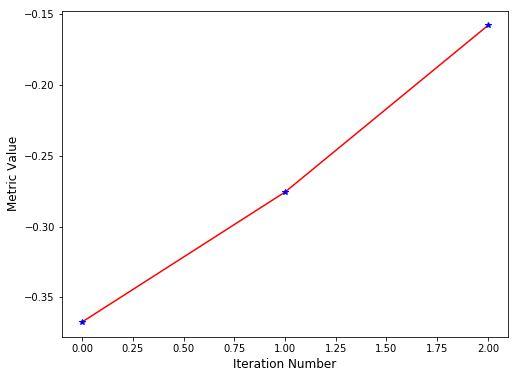

In [46]:
trans, final_trans, registration_method = reg_func(fixed_image, moving_image, 1)

In [47]:
print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))

Final metric value: -0.1579690487796368
Optimizer's stopping condition, LBFGSBOptimizerv4: Gradient tolerance reached. Gradient tolerance is 1e-06


In [48]:
moving_resampled = sitk.Resample(moving_image, fixed_image, trans, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
interact(display_images_with_alpha, image_z=(0, fixed_image.GetSize()[2]-1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled));

moving_resampled = sitk.Resample(moving_image, fixed_image, final_trans, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
interact(display_images_with_alpha, image_z=(0, fixed_image.GetSize()[2]-1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled));

seg_resampled = sitk.Resample(seg_image, fixed_image, trans, sitk.sitkLinear, 0.0, seg_image.GetPixelID())
interact(display_images_with_alpha, image_z=(0, fixed_image.GetSize()[2]-1), alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(seg_resampled));

interactive(children=(IntSlider(value=1, description='image_z', max=3), FloatSlider(value=0.5, description='alpha', max=1.0, step=0.05), Output()), _dom_classes=('widget-interact',))

interactive(children=(IntSlider(value=1, description='image_z', max=3), FloatSlider(value=0.5, description='alpha', max=1.0, step=0.05), Output()), _dom_classes=('widget-interact',))

interactive(children=(IntSlider(value=1, description='image_z', max=3), FloatSlider(value=0.5, description='alpha', max=1.0, step=0.05), Output()), _dom_classes=('widget-interact',))